多元逻辑回归案例：手写多分类问题
======
使用逻辑回归和神经网络来识别手写数字(从0到9)。逻辑回归，并将其应用于one-vs-all分类。

数据：数据以.mat格式储存，mat格式是matlab的数据存储格式，按照矩阵保存，与numpy数据格式兼容，适合于各种数学运算，因此主要使用numpy进行运算。

ex3data1中有5000个训练样例，其中每个训练样例是一个20像素×20像素灰度图像的数字，每个像素由一个浮点数表示，该浮点数表示该位置的灰度强度。每个20×20像素的网格被展开成一个400维的向量。这些每个训练样例都变成数据矩阵X中的一行。这就得到了一个5000×400矩阵X，其中每一行都是手写数字图像的训练样例。

训练集的第二部分是一个包含训练集标签的5000维向量y，“0”的数字标记为“10”，而“1”到“9”的数字按自然顺序标记为“1”到“9”。


In [159]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mp

np.set_printoptions(suppress=True, precision=6, floatmode='fixed')
## 全局设置
plt.rcParams['figure.figsize']=(8, 8)
# plt.rcParams['font.sans-serif'] = ['SimHei']
# plt.rcParams['axes.unicode_minus'] = False


# 读取数据：sio.loadmat 读取mat后，为dict类型

In [160]:
import scipy.io
data = scipy.io.loadmat('ex3data1.mat')


In [161]:
print(type(data))
print(data.keys())
print(data['X'].shape)
print(data['y'].shape)
print(data['y'])


<class 'dict'>
dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])
(5000, 400)
(5000, 1)
[[10]
 [10]
 [10]
 ...
 [ 9]
 [ 9]
 [ 9]]


# 画出数据集里的数字图片

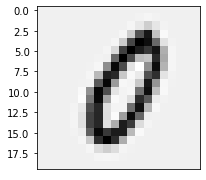

In [162]:
def plotImage(data):
    X = data['X']
    pick_one = np.random.randint(len(X))
    image = X[pick_one, :]
    fig, ax = plt.subplots(figsize=(3,3))
    ax.imshow(image.reshape(20, 20).T, cmap='gray_r')
    plt.xticks([])

plotImage(data)


(100, 400)


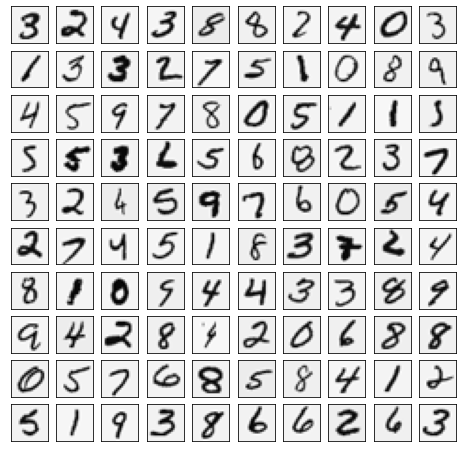

In [163]:
def plot_100_images(data):
    X = data['X']
    sample_index = np.random.choice(len(X), 100)#随机选取数据集里100个数据
    images = X[sample_index, :]
    print(images.shape)
    #定义10*10的子画布
    fig, ax = plt.subplots(ncols=10, nrows=10, figsize=(8, 8), sharex=True, sharey=True)
    #在每个子画布中画出一个数字
    for r in range(10):#行
        for c in range(10):#列
            ax[r, c].imshow(images[10 * r + c].reshape(20, 20).T, cmap='gray_r')
    #去掉坐标轴
    plt.xticks([])
    plt.yticks([])
    plt.show()

plot_100_images(data)


# 损失函数与梯度
## 定义sigmoid函数, 损失函数(含梯度)

In [164]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def computeCost(theta, X, y, lamda=1):
    '''
    COSTFUNCTIONREG Compute cost and gradient for logistic regression with regularization
       J = COSTFUNCTIONREG(theta, X, y, lambda) computes the cost of using
       theta as the parameter for regularized logistic regression and the
       gradient of the cost w.r.t. to the parameters.
    '''
    theta = theta.reshape((theta.shape[0], 1))
    m = len(y) # number of training examples
    h = sigmoid(X @ theta) # hypothesis function
    J = -1/m*np.sum(y * np.log(h) + (1-y)*np.log(1-h))
    regularized = lamda/(2*m) * np.sum( np.power(theta[1:], 2) )
    J += regularized

    grad = X.T @ (h-y) / m
    grad[1:] += (lamda/m)*theta[1:]
    return J, grad


## 测试损失函数

In [165]:
# Test case for lrCostFunction
print('\nTesting lrCostFunction() with regularization')

theta_t = np.array([[-2], [-1], [1], [2]])
X_t = np.arange(1,16).reshape(3,5).T/10
X_t = np.insert(X_t, 0, 1, axis=1)
y_t = np.array([[1], [0], [1], [0], [1]])
lambda_t = 3
J, grad = computeCost(theta_t, X_t, y_t, lambda_t)

print(f'Cost: {J:.6f}')
print('Expected cost: 2.534819')
print(f'\nGradients:\n{grad}')
print('Expected gradients:')
print(' 0.146561\n -0.548558\n 0.724722\n 1.398003')




Testing lrCostFunction() with regularization
Cost: 2.534819
Expected cost: 2.534819

Gradients:
[[ 0.146561]
 [-0.548558]
 [ 0.724722]
 [ 1.398003]]
Expected gradients:
 0.146561
 -0.548558
 0.724722
 1.398003


# 构建数据集

In [166]:
X = np.insert(data['X'], 0, values=1, axis=1) # 增加一列 x0
y = data['y'] - 1 # data 中y 范围是1~10, 代表数字0~9, 故减1
print(X.shape) # (118, 28)
print(y.shape) # (118, 1)
print(y)


(5000, 401)
(5000, 1)
[[9]
 [9]
 [9]
 ...
 [8]
 [8]
 [8]]


# 一对多分类

利用for循环对每种数字习得一个带正则的逻辑回归分类器，然后将10个分类器的参数组成一个参数矩阵theta_all返回

In [167]:
from scipy.optimize import fmin_tnc

def one_vs_all(X, y, K, lamda=1):
    n = X.shape[1] # X的列数401
    theta_all = np.zeros((K, n))#（10，401）数字0~9, 每个数字对应一组theta
    for i in range(K):
        theta_i = np.zeros(n)
        result = fmin_tnc(func=computeCost, x0=theta_i, args=(X, y == i, lamda))
        theta_all[i, :] = result[0] # fmin_tnc 返回的theta 是一维数组
    return theta_all

lamda = 1
K = 10
theta_final = one_vs_all(X, y, K, lamda)



# 训练集准确率

得到一个5000乘10的预测概率矩阵，找到每一行的概率最大的值位置，得到预测的类别，再和期望值y比较得到精度。

In [168]:
print(theta_final.shape)

def predict(X, theta_final):
    # (5000,401) (10,401) => (5000,10)
    h = sigmoid(X @ theta_final.T)#假设函数，输出h为1的概率
    h_argmax = np.argmax(h, axis=1) # 按行返回概率最大的索引, 对应数字0 ~ 9
    return h_argmax[:, np.newaxis] # 维度变为 (5000,1)

y_pred = predict(X, theta_final)
acc = np.mean(y_pred == y)

print(acc) # 0.9446


(10, 401)
0.9446
